<a href="https://colab.research.google.com/github/OllyMuh/ML_algorythms/blob/main/Random%20Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 5. Случайный лес

### Практическое задание

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random


from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

**1. Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.**

In [ ]:
# сгенерируем данные, представляющие собой 100 объектов с двумя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

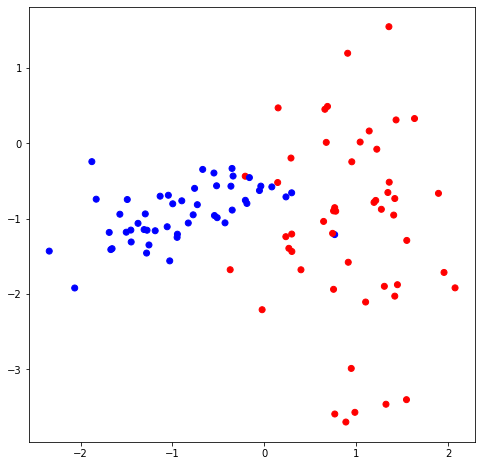

In [ ]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [ ]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [ ]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [ ]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдём класс, количество объектов которого будет максимальным в этом листе, и вернём его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [ ]:
# Расчёт критерия Джини

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [ ]:
# Расчёт качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, где в узле остаётся менее пяти объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева посредством рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай — прекращаем рекурсию, когда нет прироста качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [ ]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [ ]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [ ]:
# Введём функцию подсчёта точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

Построим лес из одного дерева.

Точность случайного леса из 1 деревьев на обучающей выборке: 94.286
Точность случайного леса из 1 деревьев на тестовой выборке: 80.000


Text(0.5, 1.0, 'Test accuracy=80.00')

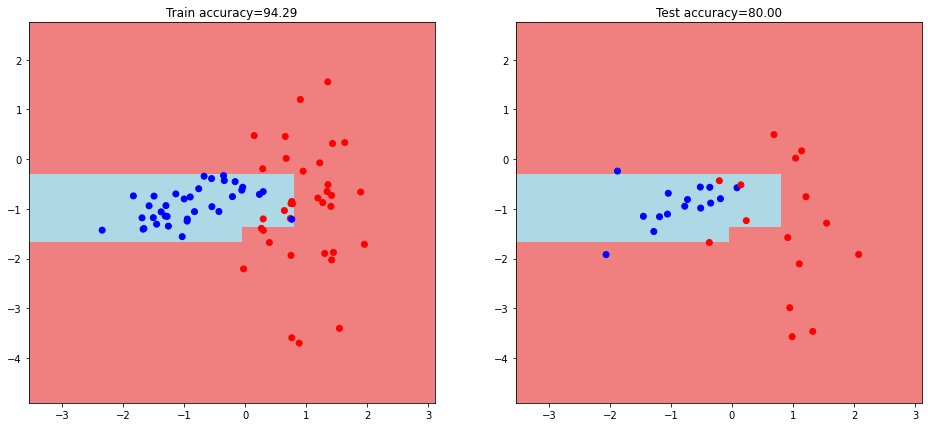

In [ ]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

# Визуализируем дерево на графике
# график обучающей выборки
plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из трёх деревьев.

Точность случайного леса из 3 деревьев на обучающей выборке: 90.000
Точность случайного леса из 3 деревьев на тестовой выборке: 70.000


Text(0.5, 1.0, 'Test accuracy=70.00')

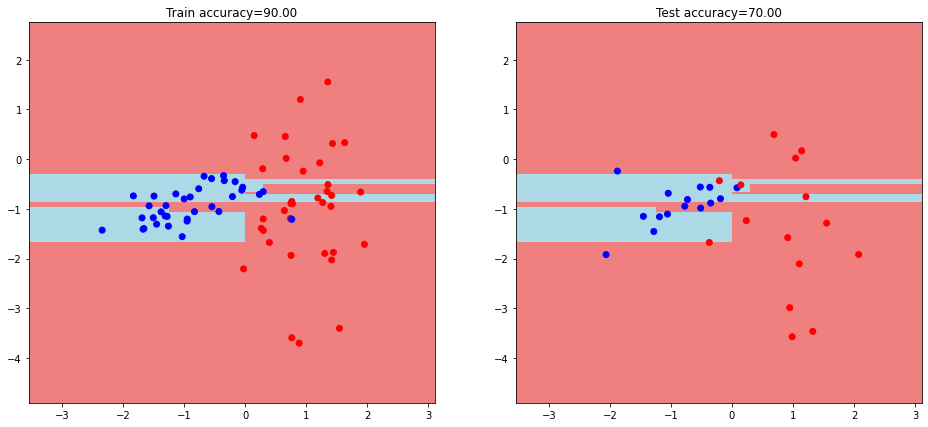

In [ ]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

# Визуализируем дерево на графике
# график обучающей выборки
plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из десяти деревьев.

Точность случайного леса из 10 деревьев на обучающей выборке: 95.714
Точность случайного леса из 10 деревьев на тестовой выборке: 86.667


Text(0.5, 1.0, 'Test accuracy=86.67')

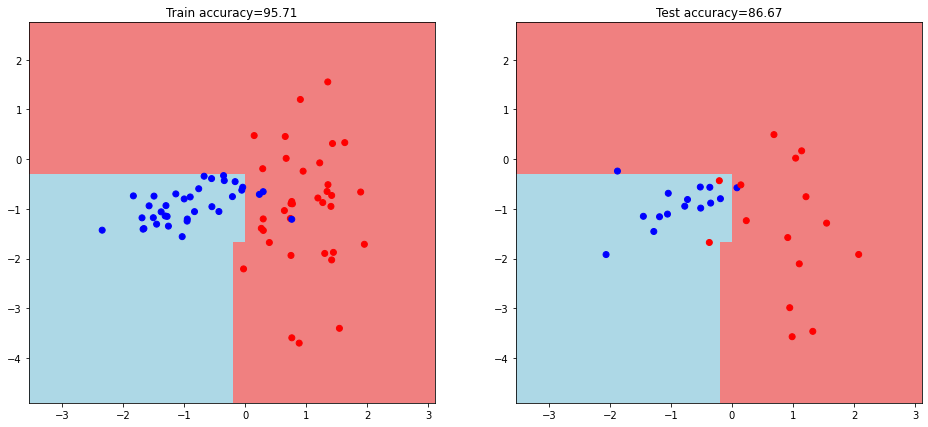

In [ ]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

# Визуализируем дерево на графике
# график обучающей выборки
plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из пятидесяти деревьев.

Точность случайного леса из 50 деревьев на обучающей выборке: 95.714
Точность случайного леса из 50 деревьев на тестовой выборке: 90.000


Text(0.5, 1.0, 'Test accuracy=90.00')

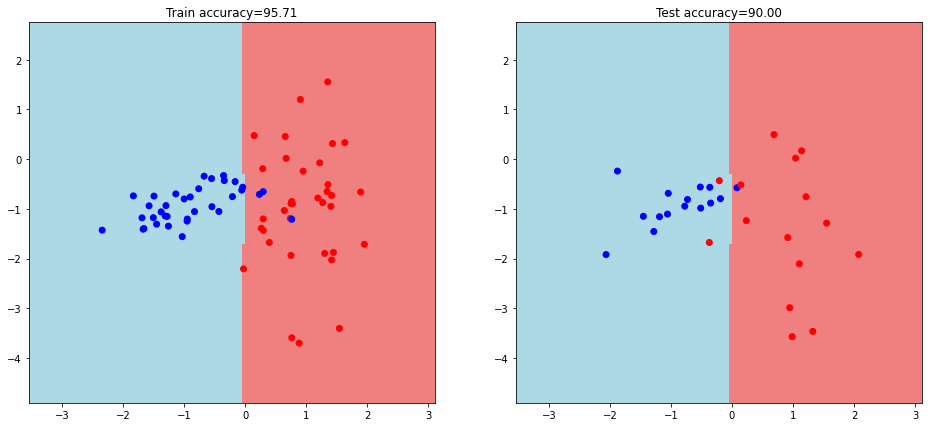

In [ ]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

# Визуализируем дерево на графике
# график обучающей выборки
plt.figure(figsize = (16, 7))
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

**2. Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.**

При малом количестве деревьев модель недообучается. Показатели качества на тестовой выборке низкие, гиперплоскость сложная.

При увеличении количества деревьев до 10 - 50 гиперплоскость становится проще и качество обучения тестовой выборки выше.

Вывод - при увеличении количества деревьев в лесу повышается качество обучения модели, модель не переобучается.

**3. Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.**

In [ ]:
def get_bootstrap(data, labels, N, oob_score):
    
    random.seed(42)
    n_samples = data.shape[0]
    bootstrap = []
    oob_examples = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        indicies = []
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            indicies.append(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        bootstrap.append((b_data, b_labels))
        
        if oob_score:
            oob_indicies = [idx for idx in range(n_samples) if idx not in set(indicies)]
            oob_data = data[oob_indicies]
            oob_labels = labels[oob_indicies]
            oob_examples.append((oob_data, oob_labels))
        
    return bootstrap, oob_examples

In [ ]:
def random_forest(data, labels, n_trees, oob_score=False):
    forest = []
    bootstrap, oob_examples = get_bootstrap(data, labels, n_trees, oob_score=oob_score)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    if oob_score:
        oob_acc = 0
        for i in range(n_trees):
            oob_acc += calc_oob_acc(oob_examples[i], forest[i])
        
        oob_acc = oob_acc / n_trees
        return forest, oob_acc
    
    return forest

In [ ]:
def calc_oob_acc(oob_examples, tree):
    oob_answers = predict(oob_examples[0], tree)
    oob_acc = accuracy_metric(oob_examples[1], oob_answers)
    return oob_acc

In [ ]:
n_trees = 50
my_forest_50, oob_score = random_forest(train_data, train_labels, n_trees, oob_score=True)

print(f'OOB Score: {oob_score:.3f}')

OOB Score: 89.663


**4. (На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.**

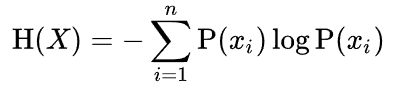

In [ ]:
# def gini(labels):
#     #  подсчёт количества объектов разных классов
#     classes = {}
#     for label in labels:
#         if label not in classes:
#             classes[label] = 0
#         classes[label] += 1
    
#     #  расчёт критерия
#     impurity = 1
#     for label in classes:
#         p = classes[label] / len(labels)
#         impurity -= p ** 2
        
#     return impurity

def calc_entropy(labels):
  #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
  # подсчет частоты каждого класса
    for label in classes:
        classes[label] = labels.count(label) / len(labels)

  # итерируемся по словарю для расчета суммы
    negative_entropy = 0
    for i in labels:
      rel_freq = classes[i]
      negative_entropy += rel_freq * log(rel_freq, 2)
      
    return -negative_entropy

In [ ]:
a, b = [0, 0, 0, 0], [0, 0, 1, 1]

print(f'Entropy of {a}: {calc_entropy(a)}')
print(f'Entropy of {b}: {calc_entropy(b)}')

Entropy of [0, 0, 0, 0]: -0.0
Entropy of [0, 0, 1, 1]: 2.0
